In [7]:
import h5py

def inspect_dataset(file_path, label=""):
    with h5py.File(file_path, 'r') as f:
        data = f['X'][:]

    print(f"\n{label} Dataset")
    print(f"Total samples: {data.shape[0]}")
    print(f"Image shape: {data.shape[1:]}")

    energy = data[:, :, :, 0]
    time = data[:, :, :, 1]

    print(f"Energy - min: {energy.min():.3f}, max: {energy.max():.3f}, mean: {energy.mean():.3f}, std: {energy.std():.3f}")
    print(f"Time   - min: {time.min():.3f}, max: {time.max():.3f}, mean: {time.mean():.3f}, std: {time.std():.3f}")

    sparsity = (energy == 0).sum() / energy.size * 100
    print(f"Energy channel sparsity: {sparsity:.2f}% (percentage of zero pixels)")

inspect_dataset("SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5", label="Photons")
inspect_dataset("SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5", label="Electrons")



Photons Dataset
Total samples: 249000
Image shape: (32, 32, 2)
Energy - min: 0.000, max: 1.485, mean: 0.001, std: 0.025
Time   - min: -2.513, max: 2.278, mean: -0.000, std: 0.065
Energy channel sparsity: 95.44% (percentage of zero pixels)

Electrons Dataset
Total samples: 249000
Image shape: (32, 32, 2)
Energy - min: 0.000, max: 1.432, mean: 0.001, std: 0.023
Time   - min: -2.513, max: 2.276, mean: -0.000, std: 0.069
Energy channel sparsity: 95.02% (percentage of zero pixels)


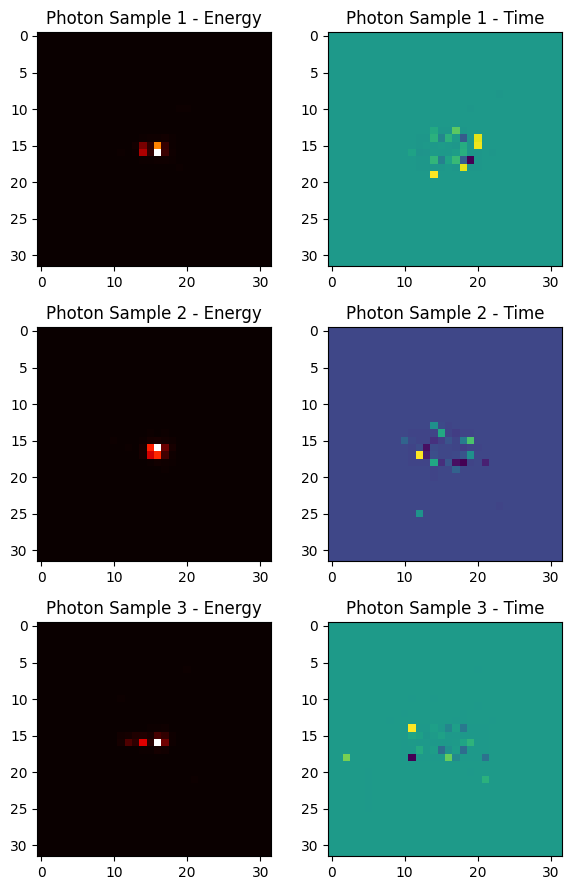

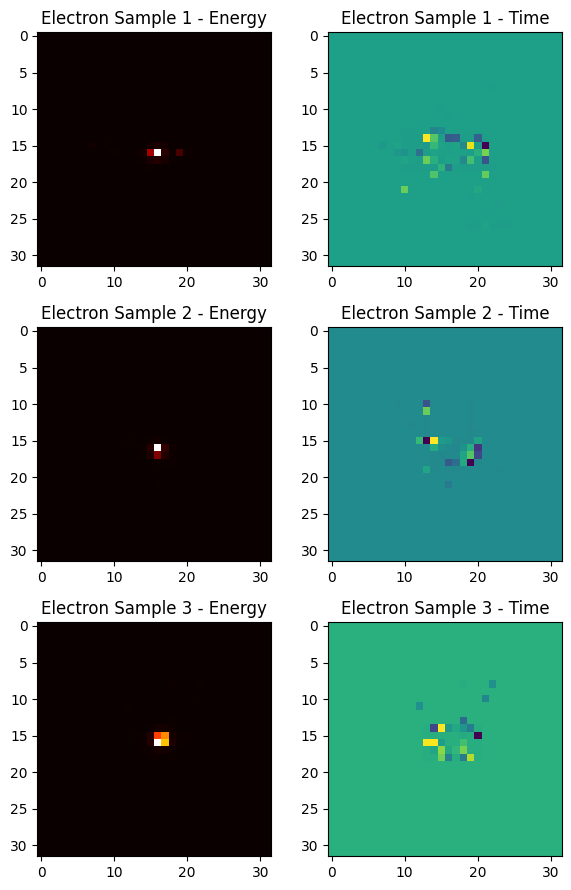

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

def load_sample_data(photon_path, electron_path, n=5):
    with h5py.File(photon_path, 'r') as f:
        photons = f['X'][:n]
    with h5py.File(electron_path, 'r') as f:
        electrons = f['X'][:n]
    return photons, electrons

def plot_samples(samples, title_prefix):
    fig, axs = plt.subplots(len(samples), 2, figsize=(6, 3 * len(samples)))
    for i, sample in enumerate(samples):
        energy = sample[:, :, 0]
        time = sample[:, :, 1]
        axs[i, 0].imshow(energy, cmap='hot')
        axs[i, 0].set_title(f"{title_prefix} Sample {i+1} - Energy")
        axs[i, 1].imshow(time, cmap='viridis')
        axs[i, 1].set_title(f"{title_prefix} Sample {i+1} - Time")
    plt.tight_layout()
    plt.show()

photon_path = "SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5"
electron_path = "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5"

photons, electrons = load_sample_data(photon_path, electron_path, n=3)
plot_samples(photons, "Photon")
plot_samples(electrons, "Electron")


In [ ]:
import h5py
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def load_data(photon_path, electron_path):
    with h5py.File(photon_path, 'r') as f:
        photons = f['X'][:]
    with h5py.File(electron_path, 'r') as f:
        electrons = f['X'][:]
    X = np.concatenate([photons, electrons], axis=0)
    y = np.concatenate([np.zeros(len(photons)), np.ones(len(electrons))])
    return X, y

class ParticleDataset(Dataset):
    def __init__(self, X, y):
        X = X.transpose(0, 3, 1, 2).astype(np.float32)
        X[:, 0] = (X[:, 0] - X[:, 0].mean()) / X[:, 0].std()
        X[:, 1] = (X[:, 1] - X[:, 1].mean()) / X[:, 1].std()
        self.X = torch.tensor(X)
        self.y = torch.tensor(y).float()

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample:
            identity = self.downsample(x)
        return self.relu(out + identity)

class ResNet15Binary(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_channels = 16
        self.conv1 = nn.Conv2d(2, 16, 3, 1, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(16, 2)
        self.layer2 = self._make_layer(32, 2, stride=2)
        self.layer3 = self._make_layer(64, 2, stride=2)
        self.layer4 = self._make_layer(128, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(128, 1)

    def _make_layer(self, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels),
            )
        layers = [BasicBlock(self.in_channels, out_channels, stride, downsample)]
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x).squeeze()

def train_model(model, train_loader, val_loader, epochs=30, patience=5, lr=1e-3):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, factor=0.5, verbose=True)

    best_val_loss = float('inf')
    best_model_state = None
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_train_loss = total_loss / len(train_loader)

        model.eval()
        val_loss = 0
        all_preds, all_probs, all_targets = [], [], []
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                probs = torch.sigmoid(outputs)
                all_probs.extend(probs.cpu().numpy())
                all_preds.extend((probs > 0.5).long().cpu().numpy())
                all_targets.extend(y_batch.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        acc = accuracy_score(all_targets, all_preds)
        auc = roc_auc_score(all_targets, all_probs)

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {acc:.4f} | AUC: {auc:.4f}")
        scheduler.step(avg_val_loss)

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping.")
                break

    model.load_state_dict(best_model_state)
    return model

def evaluate_model(model, test_loader):
    device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    model.eval()
    model.to(device)

    all_preds, all_probs, all_targets = [], [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            outputs = model(X_batch)
            probs = torch.sigmoid(outputs)
            preds = (probs > 0.5).long()
            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(y_batch.numpy())

    acc = accuracy_score(all_targets, all_preds)
    cm = confusion_matrix(all_targets, all_preds)
    auc = roc_auc_score(all_targets, all_probs)

    print("Test Accuracy:", acc)
    print("Confusion Matrix:\n", cm)
    print("ROC AUC Score:", auc)

In [2]:
X, y = load_data("SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5", "SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
train_dataset = ParticleDataset(X_train, y_train)
test_dataset = ParticleDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=256)
model = ResNet15Binary()
model = train_model(model, train_loader, test_loader)

/Users/alexandramurariu/Documents/gsoc-task/.venv/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30 | Train Loss: 0.6056 | Val Loss: 0.5907 | Val Acc: 0.6945 | AUC: 0.7605
Epoch 2/30 | Train Loss: 0.5645 | Val Loss: 0.6145 | Val Acc: 0.6980 | AUC: 0.7770
Epoch 3/30 | Train Loss: 0.5559 | Val Loss: 0.6060 | Val Acc: 0.6813 | AUC: 0.7547
Epoch 4/30 | Train Loss: 0.5510 | Val Loss: 0.5609 | Val Acc: 0.7189 | AUC: 0.7897
Epoch 5/30 | Train Loss: 0.5476 | Val Loss: 0.5450 | Val Acc: 0.7328 | AUC: 0.7995
Epoch 6/30 | Train Loss: 0.5460 | Val Loss: 0.5504 | Val Acc: 0.7250 | AUC: 0.7940
Epoch 7/30 | Train Loss: 0.5444 | Val Loss: 0.5440 | Val Acc: 0.7308 | AUC: 0.8003
Epoch 8/30 | Train Loss: 0.5429 | Val Loss: 0.5786 | Val Acc: 0.7025 | AUC: 0.7889
Epoch 9/30 | Train Loss: 0.5417 | Val Loss: 0.5611 | Val Acc: 0.7183 | AUC: 0.7889
Epoch 10/30 | Train Loss: 0.5404 | Val Loss: 0.5454 | Val Acc: 0.7321 | AUC: 0.8006
Epoch 11/30 | Train Loss: 0.5342 | Val Loss: 0.5457 | Val Acc: 0.7301 | AUC: 0.8053
Epoch 12/30 | Train Loss: 0.5326 | Val Loss: 0.5334 | Val Acc: 0.7385 | AUC: 0.8089
E

In [3]:
evaluate_model(model, test_loader)
torch.save(model.state_dict(), "resnet15_electron_photon.pt")

Test Accuracy: 0.7416465863453815
Confusion Matrix:
 [[35920 13880]
 [11852 37948]]
ROC AUC Score: 0.8127537184884114



These results show that the model can differentiate electrons from photons with **moderate accuracy**, even under heavy sparsity (∼95%) in the energy channel. Future improvements could include:
- Incorporating geometric inductive biases (e.g. SE(2) equivariant models)
- Using time-energy correlation or graph-based architectures
